In [22]:
from pathlib import Path

project_dir = Path('.').absolute().parent
project_dir

PosixPath('/home/daniel/Documents/github/mcx-lab/rl-baselines3-zoo')

In [23]:
import gym 
import utils.import_envs

env = gym.make("A1GymEnv-v0")
foot_names = env.robot.GetFootNames()

Init CPG gait=walk, duty_factor=0.5, period=0.6666666666666666
argv[0]=


/home/daniel/anaconda3/envs/rl-baselines-zoo-cu113/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


# Inspect logged inputs / outputs

Logs generated with `scripts/enjoy_with_logging.py`

In [24]:
import numpy as np
import pickle 
import json

def load_robot_states(stats_dir):
    base_position = np.load(stats_dir / 'base_position.npy')
    base_velocity = np.load(stats_dir / 'base_velocity.npy')
    motor_position = np.load(stats_dir / 'motor_position.npy')
    motor_velocity = np.load(stats_dir / 'motor_velocity.npy')
    ref_displacement = np.load(stats_dir / 'reference_displacement.npy')
    act_displacement = np.load(stats_dir / 'actual_displacement.npy')
    ref_foot_contacts = np.load(stats_dir / 'reference_foot_contact.npy')
    act_foot_contacts = np.load(stats_dir / 'actual_foot_contact.npy')
    nn_observations = np.load(stats_dir / 'nn_observations.npy')

    reward_component_values = np.load(stats_dir / 'reward_components.npy')
    with open(stats_dir / 'reward_component_names.json', 'r') as file:
        reward_component_names = json.load(file)
    print(nn_observations.shape)
    nn_actions = np.load(stats_dir / 'nn_actions.npy')
    time = np.load(stats_dir / 'time.npy')
    
    return {
        'time': time, 
        'base_pos': base_position,
        'base_vel': base_velocity,
        'motor_pos': motor_position, 
        'motor_vel': motor_velocity, 
        'ref_displacement': ref_displacement,
        'act_displacement': act_displacement,
        'ref_foot_contacts': ref_foot_contacts, 
        'act_foot_contacts': act_foot_contacts, 
        'nn_obs': nn_observations,
        'nn_act': nn_actions,
        'reward_component_values': reward_component_values,
        'reward_component_names': reward_component_names
    }

def load_normalizer(model_dir):
    with open(model_dir / 'A1GymEnv-v0' / 'vecnormalize.pkl', 'rb') as file:
        normalizer = pickle.load(file)
    return normalizer

In [25]:
model_dir = project_dir / 'logs' / 'ppo' / 'A1GymEnv-v0_8'

import itertools

DEFAULT_GAIT_FREQUENCY = (1.5,)
ALL_GAIT_FREQUENCIES = (1.1, 1.3, 1.5, 1.7, 1.9)
DEFAULT_DUTY_FACTOR = (0.75,)
ALL_DUTY_FACTORS = (0.55, 0.65, 0.75, 0.85)

settings = itertools.chain(
    itertools.product(DEFAULT_GAIT_FREQUENCY, ALL_DUTY_FACTORS),
    itertools.product(ALL_GAIT_FREQUENCIES, DEFAULT_DUTY_FACTOR)
)



stats_dirs = [
    model_dir / 'trot-1.5Hz-0.5df',
    model_dir / 'trot-2.0Hz-0.5df',
    model_dir / 'trot-2.5Hz-0.5df',
    model_dir / 'walk-1.5Hz-0.75df',
    model_dir / 'walk-2.0Hz-0.75df',
    model_dir / 'walk-2.5Hz-0.75df',
]

statss = [load_robot_states(sd) for sd in stats_dirs]
normalizer = load_normalizer(model_dir)

(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)


## Generate Poster plots

In [26]:
plot_stats_dirs = [
    model_dir / 'trot-2.0Hz-0.5df',
    model_dir / 'walk-2.0Hz-0.75df',
]

plot_statss = [load_robot_states(sd) for sd in stats_dirs]

(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)


In [27]:
import matplotlib.pyplot as plt

google_blue = (66 / 256, 133 / 256, 244 / 256, 1)
google_red = (219 / 256, 68 / 256, 55 / 256, 1)
google_yellow = (244 / 256, 180 / 256, 0, 1)
google_green = (15 / 256, 157 / 256, 88 / 256, 1)

foot_names = ['FR', 'FL', 'RR', 'RL']
foot_colors = [google_blue, google_red, google_yellow, google_green]

def plot_foot_contacts(ax, time, foot_contacts, title):
    
    ax.set_yticks([0,1,2,3])
    ax.set_yticklabels(foot_names)
    for i in range(4):
        # Select timesteps where foot is on ground
        ground_idx = foot_contacts[:,i] == 1
        ax.set_title(title)
        ax.axhline(y=i+0.5, color='black', linestyle='--')
        ax.fill_between(time, i-0.3, i+0.3, where=ground_idx, color = foot_colors[i])


[0.85852 0.88064 0.70512 0.76724] 0.80288
[0.9238  0.88172 0.59836 0.84284] 0.81168


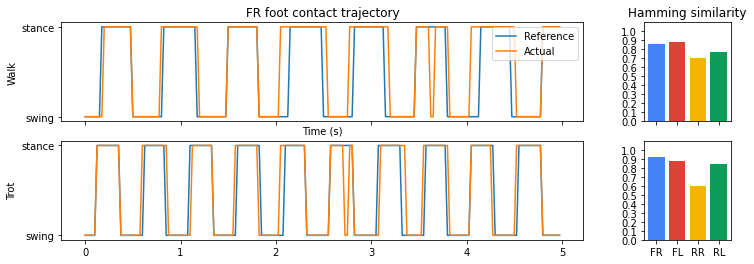

In [28]:
NUM_TIMESTEPS = 200

def calc_hamming_sim(stats, stats_dir):
    time = stats['time']
    ref_foot_contacts = stats['ref_foot_contacts']
    act_foot_contacts = stats['act_foot_contacts']

    # Divide by 2 since binary entries are [-1, 1] and not [0,1]
    diff = np.abs(ref_foot_contacts - act_foot_contacts) / 2
    hamming_dist = np.mean(diff, axis=0)
    hamming_sim = 1 - hamming_dist
    return hamming_sim

def plot_foot_contact_sequence(ax, stats, stats_dir, foot_index = 0, prefix=""):
    import matplotlib.pyplot as plt 
    
    time = stats['time']
    ref_foot_contacts = stats['ref_foot_contacts']
    act_foot_contacts = stats['act_foot_contacts']
    act_foot_contacts = 2 * (act_foot_contacts > 0) - 1
    
    # fig.suptitle(stats_dir.name)
    
    hamming_sim = calc_hamming_sim(stats, stats_dir)
    print(hamming_sim, np.mean(hamming_sim))

    ax[0].set_ylabel(f"{prefix}")
    ax[0].plot(time[:NUM_TIMESTEPS], ref_foot_contacts[:NUM_TIMESTEPS, foot_index], label = 'Reference')
    ax[0].plot(time[:NUM_TIMESTEPS], act_foot_contacts[:NUM_TIMESTEPS, foot_index], label = 'Actual')
    ax[0].set_yticks([-1,1])
    ax[0].set_yticklabels(['swing', 'stance'])

    # Plot hamming similarity
    ax[1].set_ylim(0.0, 1.1)
    ax[1].set_yticks([i / 10 for i in range(11)])
    ax[1].set_xticks([0,1,2,3])
    ax[1].set_xticklabels(foot_names)
    ax[1].bar([0,1,2,3], hamming_sim, color = foot_colors)

fig, ax = plt.subplots(2, 2, figsize=(12,4.0), gridspec_kw={'width_ratios':(6,1)}, sharex='col')
ax[0,0].set_title("FR foot contact trajectory")
ax[0,0].set_xlabel("Time (s)")
ax[0,1].set_title("Hamming similarity")
prefixes = ('Walk', 'Trot', 'Canter', 'Pace')
for i, (stats, stats_dir) in enumerate(zip(plot_statss, plot_stats_dirs)):
    plot_foot_contact_sequence(ax[i], stats, stats_dir, prefix=prefixes[i])
ax[0,0].legend()
# fig.tight_layout()
fig.savefig("ref_act_foot_contact_walk_trot.png", format="png", bbox_inches="tight")
    

(1000, 1, 76)
(1000, 1, 76)
[0.90228 0.86452 0.70824 0.85364] 0.83217
[0.7066  0.74544 0.54844 0.54072] 0.6352999999999999


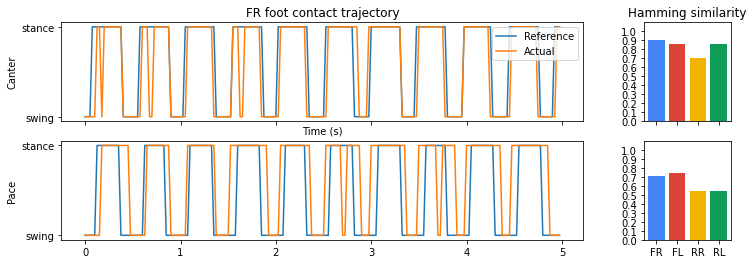

In [29]:
plot_stats_dirs = [
    model_dir / 'canter-2.0Hz-0.66df',
    model_dir / 'pace-2.0Hz-0.5df',
]

plot_statss = [load_robot_states(sd) for sd in plot_stats_dirs]

fig, ax = plt.subplots(2, 2, figsize=(12,4.0), gridspec_kw={'width_ratios':(6,1)}, sharex='col')
ax[0,0].set_title("FR foot contact trajectory")
ax[0,0].set_xlabel("Time (s)")
ax[0,1].set_title("Hamming similarity")
prefixes = ('Canter', 'Pace')
for i, (stats, stats_dir) in enumerate(zip(plot_statss, plot_stats_dirs)):
    plot_foot_contact_sequence(ax[i], stats, stats_dir, prefix=prefixes[i])
ax[0,0].legend()
# fig.tight_layout()
fig.savefig("ref_act_foot_contact_canter_pace.png", format="png", bbox_inches="tight")

## Estimate Hamming Sims

In [30]:
import itertools 

gaits = ('trot', 'walk')
gfs = (1.5, 2.0, 2.5)
dfs = (0.5, 0.6, 0.75)

settings = itertools.product(gaits, gfs, dfs)
dirnames = [f"{gait}-{gf}Hz-{df}df" for gait, gf, df in settings]

eval_stats_dirs = [
    model_dir / dirname for dirname in dirnames
]

eval_statss = [load_robot_states(sd) for sd in eval_stats_dirs]

(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)


Estimate the duty factor at each time period? 

In [35]:
def estimate_hamming_sim(stats, stats_dir):
    time = stats['time']
    ref_foot_contacts = stats['ref_foot_contacts']
    act_foot_contacts = stats['act_foot_contacts']

    hamming_dist = np.mean(np.abs(act_foot_contacts - ref_foot_contacts) / 2)
    hamming_sim = 1 - hamming_dist
    return (stats_dir.name, round(hamming_sim, 2))

h_sims = []
for stats, stats_dir in zip(eval_statss, eval_stats_dirs):
    name, h_sim = estimate_hamming_sim(stats, stats_dir)
    print(name, h_sim)
    h_sims.append(h_sim)
print()
print("Average H-sim", np.mean(h_sims), np.std(h_sims))

trot-1.5Hz-0.5df 0.8
trot-1.5Hz-0.6df 0.87
trot-1.5Hz-0.75df 0.85
trot-2.0Hz-0.5df 0.81
trot-2.0Hz-0.6df 0.87
trot-2.0Hz-0.75df 0.86
trot-2.5Hz-0.5df 0.8
trot-2.5Hz-0.6df 0.83
trot-2.5Hz-0.75df 0.83
walk-1.5Hz-0.5df 0.75
walk-1.5Hz-0.6df 0.8
walk-1.5Hz-0.75df 0.84
walk-2.0Hz-0.5df 0.83
walk-2.0Hz-0.6df 0.85
walk-2.0Hz-0.75df 0.86
walk-2.5Hz-0.5df 0.82
walk-2.5Hz-0.6df 0.85
walk-2.5Hz-0.75df 0.85

Average H-sim 0.8316666666666666 0.03004626062886656


In [36]:
gaits = ('canter',)
gfs = (1.5, 2.0, 2.5)
dfs = (0.5, 0.6, 0.75)

settings = itertools.product(gaits, gfs, dfs)
dirnames = [f"{gait}-{gf}Hz-{df}df" for gait, gf, df in settings]

eval_stats_dirs = [
    model_dir / dirname for dirname in dirnames
]

eval_statss = [load_robot_states(sd) for sd in eval_stats_dirs]

h_sims = []
for stats, stats_dir in zip(eval_statss, eval_stats_dirs):
    name, h_sim = estimate_hamming_sim(stats, stats_dir)
    print(name, h_sim)
    h_sims.append(h_sim)
print()
print("Average H-sim", np.mean(h_sims), np.std(h_sims))

(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
canter-1.5Hz-0.5df 0.73
canter-1.5Hz-0.6df 0.75
canter-1.5Hz-0.75df 0.79
canter-2.0Hz-0.5df 0.82
canter-2.0Hz-0.6df 0.83
canter-2.0Hz-0.75df 0.82
canter-2.5Hz-0.5df 0.79
canter-2.5Hz-0.6df 0.81
canter-2.5Hz-0.75df 0.85

Average H-sim 0.7988888888888889 0.03634539385288027


In [37]:
gaits = ('pace',)
gfs = (1.5, 2.0, 2.5)
dfs = (0.5, 0.6, 0.75)

settings = itertools.product(gaits, gfs, dfs)
dirnames = [f"{gait}-{gf}Hz-{df}df" for gait, gf, df in settings]

eval_stats_dirs = [
    model_dir / dirname for dirname in dirnames
]

eval_statss = [load_robot_states(sd) for sd in eval_stats_dirs]

h_sims = []
for stats, stats_dir in zip(eval_statss, eval_stats_dirs):
    name, h_sim = estimate_hamming_sim(stats, stats_dir)
    print(name, h_sim)
    h_sims.append(h_sim)
print()
print("Average H-sim", np.mean(h_sims), np.std(h_sims))

(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
(1000, 1, 76)
pace-1.5Hz-0.5df 0.55
pace-1.5Hz-0.6df 0.59
pace-1.5Hz-0.75df 0.65
pace-2.0Hz-0.5df 0.63
pace-2.0Hz-0.6df 0.66
pace-2.0Hz-0.75df 0.62
pace-2.5Hz-0.5df 0.57
pace-2.5Hz-0.6df 0.65
pace-2.5Hz-0.75df 0.69

Average H-sim 0.6233333333333333 0.042946995755750415
